In [14]:
import numpy as np
from matplotlib import pyplot as plt
import csv
from datetime import datetime

Modifiable Parmas
==================

Change the parameters in the following cell to change properties of the plot at the bottom

In [173]:
field = ['cases', 'deaths'][0] # switch index to do cases vs deaths
# Note that as of April 29, "deaths" are noisy for states other than, e.g., New York, New Jersey

state = 'Georgia' # switch to, e.g., 'New York'
# set to None to view the top counties in the entire US
# set to a list to aggregate all counties from all states in the list
# e.g.
# state = ['Virginia', 'Maryland', 'District of Columbia']

magic_date = "2020-04-24" # date to highlight on plots
# "2020-03-19" is the start of the California Shelter-In-Place
# "2020-03-17" is the start of the Bay Area Shelter-In-Place
# "2020-03-20" is the start of the New York State SIP
# "2020-03-30" is the DC/Maryland/Virginia SIP
# "2020-03-31" is the Tennessee SIP start
# "2020-04-07" is the infamous Wisconsin election
# "2020-04-24" is the Georgia re-opening date

magic_date_name = "shelter in place"

offset_magic_date_by = [5, # estimated incubation period of COVID-19
                        12, # a few days after estimated incubation period of COVID-19
                       ] # make this list empty to eliminate all magic date markers
# offset_magic_date_by = [] # uncomment to eliminate all date markers

show_this_many_counties = 6 # You probably don't want to exceed 12 here

In [174]:
# The following are paremeters affecting how the program displays and computes data
smoothing_window = 10 # use any positive integer, but values above 5 work best
magic_date_marker_size = 20


Read the data
=============

Code and helper utils for actually ingesting the data

In [175]:
fname = "covid-19-data/us-counties.csv"

In [176]:
csv_reader = csv.DictReader(open(fname))
if state is not None: # if we're filtering by state
    if type(state) == type([]):
        data = []
        print(state)
        for entry in csv_reader:
            if not entry['state'] in state:
                continue
            entry['county'] = entry['state'] + " - " + entry['county']
            data.append(entry)
    else:
        data = [d for d in csv_reader if d['state'] == state]
else:
    data = []
    for entry in csv_reader:
        entry['county'] = entry['state'] + " - " + entry['county']
        data.append(entry)

In [177]:
def entry_to_days(entry):
    """Converts a YYYY-mm-dd date into an integer with 0 being 2020-01-01"""
    d1 = datetime.strptime(entry['date'], "%Y-%m-%d")
    d0 = datetime.strptime("2020-01-01", "%Y-%m-%d")
    return(d1 - d0).days

# then we convert our magic date to a number
magic_date_nums = [entry_to_days({'date': magic_date}) + i for i in offset_magic_date_by]
magic_date_nums

[119, 126]

In [178]:
# Here we just peek at a cell in the data
data[0]

OrderedDict([('date', '2020-03-02'),
             ('county', 'Fulton'),
             ('state', 'Georgia'),
             ('fips', '13121'),
             ('cases', '2'),
             ('deaths', '0')])

In [179]:
# Now we extract data for all counties in this state
counties = {}
for d in data:
    l = counties.get(d['county'], [])
    l.append([entry_to_days(d), d[field]])
    counties[d['county']] = l

In [180]:
len(counties)

159

Code to extract a trajectory for an individual county and plot it
========================

The following functions extract
1. the time series of cumulative caseload for a given county
2. the time series of the average daily change in cumulative caseload over the past "window" days
3. a time series of integers corresponding to number of days after 2020-01-01

and then provide utilities for plotting the average daily change on the y axis
against the cumulative caseload on the x axis on a plot in which each axis
is logarithmically scaled.

Overview of plot meaning
-------------------------------------

For many (but certainly not all) common dynamical systems, a "phase plot" or "phase portrait"
of a time series can be made by plotting a key value of the system on the x axis, plotting
the rate of change of that value on the y axis, and not explicitly plotting time.
(The technical definition of a phase portrait is very different from this,
but the two match up for many of the sorts of systems seen in basic physics).

Such plots highlight certain aspects of a given time series while de-emphasizing others.

In particular, for rapidly growing functions, a phase portrait in which each axis is on
a log scale quickly and easily reveals which family of functions the growth of the quantity
most resembles, rather than what the instantaneous growth rate is.

Purely exponential growth corresponds to lines in this plot with a slope of `1`.
Changing the base of the exponent merely shifts these lines up or down in the plot without
changing their slope.
Quadratic growth corresponds to lines in this plot with a slope of `1/2`.
Polynomial growth with a power of `p` produces lines with a slope of `(p-1)/p`

In [181]:
def trajectory(county, window=5):
    """This just extracts the time series of cumulative caseload, the time series
    of the smoothe (but laggy) rate of change of cumulative caseload, and, to aid
    in marker placement, the time series of date indices (# of days since a reference date)"""
    raw = sorted(counties[county], key = lambda e: e[0])
    date_nums = [raw[i][0] for i in range(window, len(raw))]
    rates = [(float(raw[i][1]) - float(raw[i-window][1])) / (raw[i][0] - raw[i-window][0])
             for i in range(window, len(raw))]
    cums = [float(r[1]) for r in raw[window:]]
    indices = [i for i in range(len(cums)) if cums[i] > 1 and rates[i] > 1]
    return [[cums[i] for i in indices], [rates[i] for i in indices], [date_nums[i] for i in indices]]

In [182]:
def plot_traj(county, color, window=5):
    """This plots the time series extracted by the
    'trajectory' function on a log/log plot.
    
    It also marks where the trajectory is at any dates
    corresponding to n days after 'magic_date' for each
    n in `offset_magic_date_by`."""
    data = trajectory(county, window=window)
    plt.yscale('log')
    plt.xscale('log')
    plt.ylabel('average new ' + field +' per day')
    plt.xlabel('cumulative ' + field)
    plt.plot(data[0], data[1], color, label=county)
    magic_date_color = color[0] + "o"
    magic_date_index = [i for i in range(len(data[0])) if data[2][i] in magic_date_nums]
    if len(magic_date_index) > 0:
        plt.plot([data[0][i] for i in magic_date_index], [data[1][i] for i in magic_date_index], magic_date_color,
                markersize = magic_date_marker_size)
        # uncomment the next two lines to get a feel for the growth rate via printouts, and double-check estimates
        # of growth rates
        # for i in magic_date_index:
        #    print(county + " on date " + str(i) + " has state " + str((data[0][i], data[1][i])))

Helper class for grabbing different colors and line styles for plotting

In [183]:
class ColorPicker:
    def __init__(self):
        self.colors = [c + "-" for c in "kbrgcm"] + [c + "--" for c in "kbrgcm"]
        self.i = 0
    def get(self):
        c = self.colors[self.i]
        self.i += 1
        self.i = self.i % len(self.colors)
        return c




THE ACTUAL PLOTS
================

The part you've been waiting for, amirite?

Fulton cumulative cases : 3057.0
DeKalb cumulative cases : 2255.0
Gwinnett cumulative cases : 2057.0
Cobb cumulative cases : 1839.0
Hall cumulative cases : 1776.0
Dougherty cumulative cases : 1543.0
shifted exponential reference line multiplies doubling time by 2.9679611650485436
curves lining up with upper exponential have doubling times of approximately 6.93 days
curves lining up with lower exponential have doubling times of approximately 20.57 days


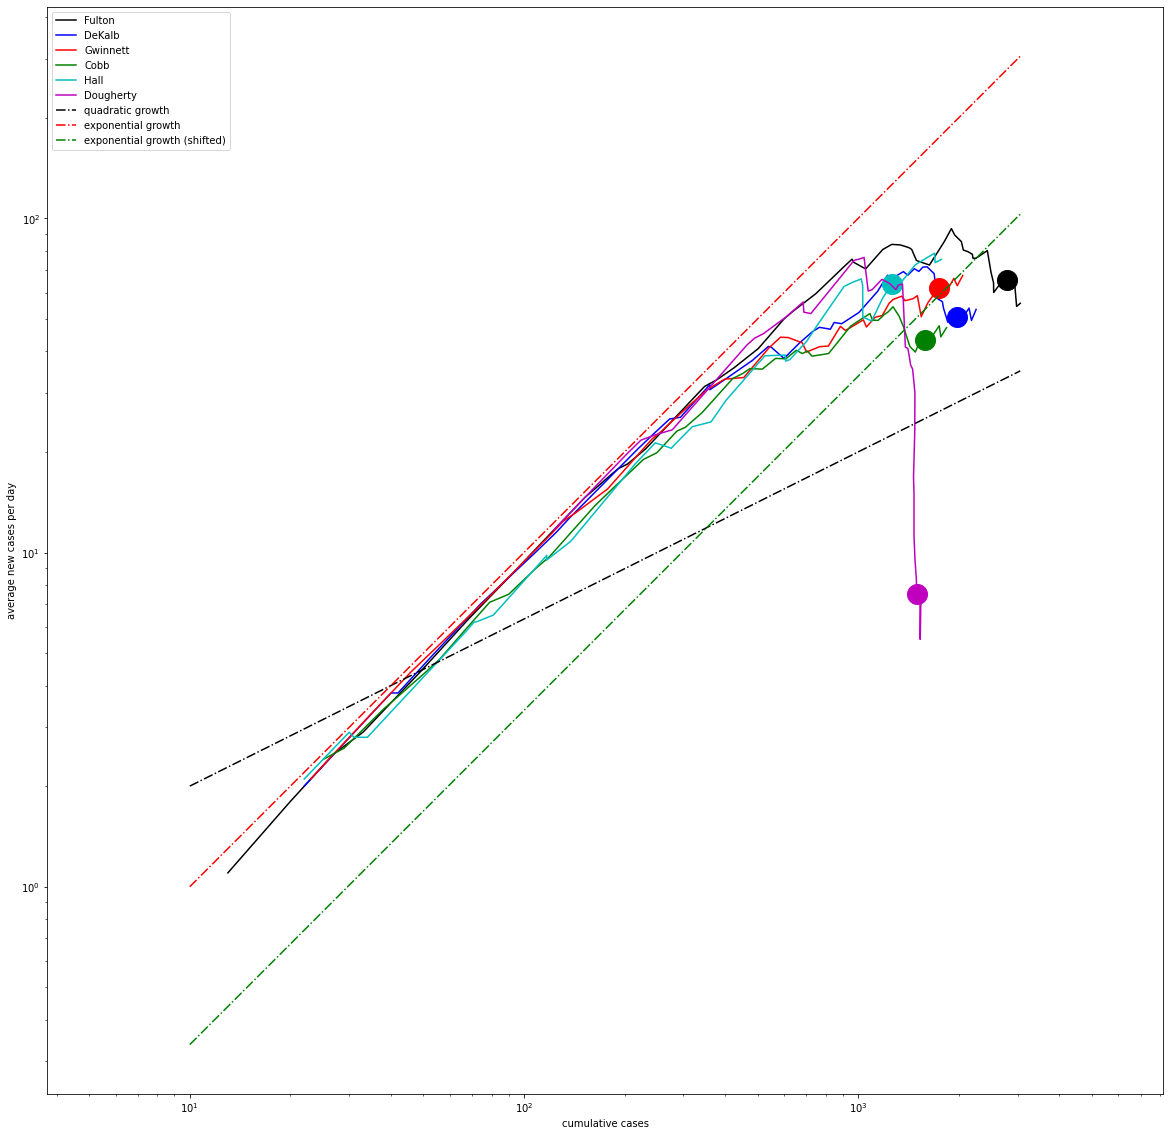

In [184]:
col_pick = ColorPicker()
plt.rcParams['figure.figsize'] = [20,20]
plt.axes().set_aspect('equal', 'datalim')
maxpt = 0.0
maxrate = 0.0
valid_counties = [c for c in counties.keys() if len(trajectory(c)[0]) > smoothing_window and c != 'Unknown']
valid_counties = sorted(valid_counties, key=lambda c: -1.0 * trajectory(c)[0][-1])
for county in valid_counties[:show_this_many_counties]:
    t = trajectory(county)
    plot_traj(county, col_pick.get(), window=smoothing_window)
    print(county + " cumulative " + field + " : "+ str(trajectory(county)[0][-1]))
    maxpt = max(maxpt, t[0][-1])
    maxrate = max(maxrate, t[1][-1])
plt.plot([10.0, maxpt], [2.0, 2.0 * np.sqrt(0.1 * maxpt)], 'k-.', label="quadratic growth")
plt.plot([10.0, maxpt], [1.0, 0.1 * maxpt], 'r-.', label="exponential growth")
plt.plot([10.0, maxpt], [10.0 * maxrate / maxpt, maxrate], 'g-.', label="exponential growth (shifted)")
plt.legend()
print("shifted exponential reference line multiplies doubling time by " + str(0.1 * maxpt/maxrate))
print("curves lining up with upper exponential have doubling times of approximately " +
      "{:.2f}".format(np.log(2)/0.1) + " days")
print("curves lining up with lower exponential have doubling times of approximately " + 
      "{:.2f}".format(np.log(2)*maxpt/maxrate) + " days")